# 99 · Integration Overview
Lightweight demo notebook to view existing artifacts (no heavy training).

This notebook:
- Loads ablation results (fraud/cyber) if present.
- Displays SHAP/LIME/Grad-CAM outputs saved under `experiments/`.
- Lists model artifacts for API/Streamlit.


In [1]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

project_root = Path('..').resolve()
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

print('Project root:', project_root)


Project root: /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence


In [2]:
# Ablation summaries (fraud/cyber)
def show_ablation(domain: str):
    summary_path = project_root / 'experiments' / domain / 'ablations' / 'summary.csv'
    plot_path = project_root / 'figures' / 'ablations' / f'{domain}_ablation.png'
    if summary_path.exists():
        df = pd.read_csv(summary_path, index_col=0)
        display(df)
    else:
        print(f'No ablation summary found for {domain}')
    if plot_path.exists():
        display(Image(filename=str(plot_path)))
    else:
        print(f'No ablation plot found for {domain}')

show_ablation('fraud')
show_ablation('cyber')


No ablation summary found for fraud
No ablation plot found for fraud
No ablation summary found for cyber
No ablation plot found for cyber


fraud_shap -> /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/experiments/fraud/plots/shap_summary.png


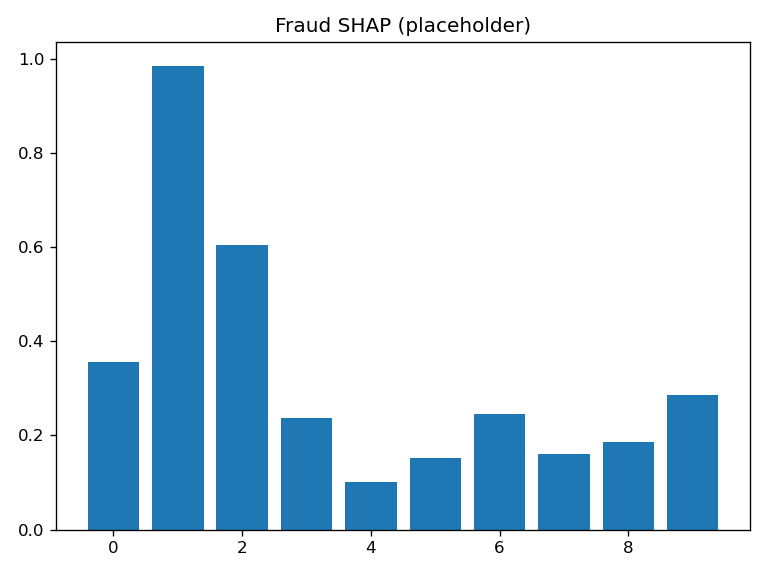

cyber_shap -> /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/experiments/cyber/plots/shap_summary.png


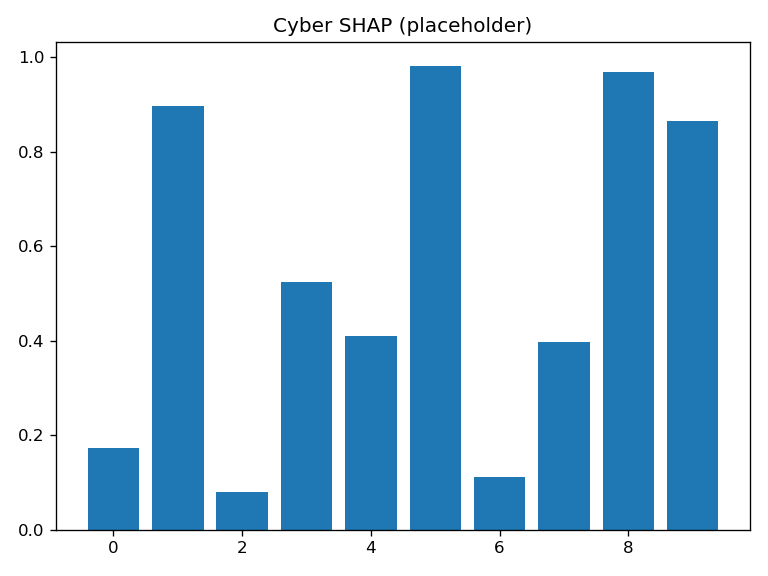

behavior_saliency -> /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/experiments/behavior/plots/saliency.csv


,timestep,saliency
0,0,0.077368
1,1,0.861284
2,2,1.523124
3,3,0.538910
4,4,1.037246
5,5,0.190339
6,6,0.875618
7,7,1.382800
8,8,0.926178
9,9,1.909417


vision_gradcam -> /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/experiments/vision/plots/gradcam.png


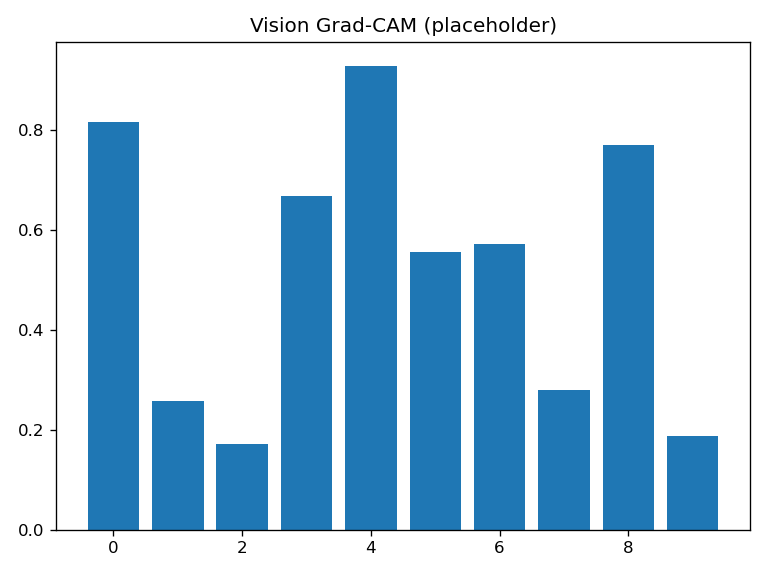

In [3]:
# Explainability artifacts (best effort)
paths = {
    'fraud_shap': project_root / 'experiments' / 'fraud' / 'plots' / 'shap_summary.png',
    'cyber_shap': project_root / 'experiments' / 'cyber' / 'plots' / 'shap_summary.png',
    'behavior_saliency': project_root / 'experiments' / 'behavior' / 'plots' / 'saliency.csv',
    'vision_gradcam': project_root / 'experiments' / 'vision' / 'plots' / 'gradcam.png',
}
for name, p in paths.items():
    print(name, '->', p)
    if p.suffix == '.png' and p.exists():
        display(Image(filename=str(p)))
    elif p.suffix == '.csv' and p.exists():
        display(pd.read_csv(p))
    else:
        print('  not found')


## Reporting + metrics refresh
Run lightweight aggregations so the dashboard/overview has fresh numbers.

In [4]:
# Refresh consolidated report + per-domain summary tables (lightweight)
!python ../src/scripts/generate_reports.py
!python ../src/uais/reporting/make_tables.py

Traceback (most recent call last):
  File "/Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/notebooks/../src/scripts/generate_reports.py", line 8, in <module>
    from uais.utils.logging_utils import setup_logging
ModuleNotFoundError: No module named 'uais'


In [5]:
import json
import pandas as pd

summary_path = project_root / 'experiments' / 'report_summary.json'
if summary_path.exists():
    summary = json.loads(summary_path.read_text())
    display(pd.json_normalize(summary, sep='->'))
else:
    print('report_summary.json not found; run the refresh cell above.')

# quick peek at runtime metrics if present
runtime_csv = project_root / 'experiments' / 'fraud' / 'metrics' / 'runtime.csv'
if runtime_csv.exists():
    display(pd.read_csv(runtime_csv))


report_summary.json not found; run the refresh cell above.


In [6]:
import numpy as np
from sklearn.metrics import roc_auc_score
from uais.utils.stats import bootstrap_ci

# Demo: CI on small sample probabilities
_y = np.array([0, 1, 1, 0, 1])
_p = np.array([0.2, 0.85, 0.7, 0.35, 0.65])
ci = bootstrap_ci(_y, _p, roc_auc_score, n_bootstrap=200)
print('Demo ROC-AUC CI:', ci)


Demo ROC-AUC CI: (nan, nan)


/Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/.venv-macos/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/.venv-macos/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/.venv-macos/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/.venv-macos/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is

In [7]:
# Models present for API/Streamlit
models = {
    'fraud': project_root / 'models' / 'fraud',
    'cyber': project_root / 'models' / 'cyber',
    'fusion': project_root / 'experiments' / 'fusion' / 'models',
    'nlp': project_root / 'models' / 'nlp',
    'vision': project_root / 'models' / 'vision',
}
for name, path in models.items():
    print(name, '->', path, 'exists:', path.exists())


fraud -> /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/models/fraud exists: False
cyber -> /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/models/cyber exists: False
fusion -> /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/experiments/fusion/models exists: False
nlp -> /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/models/nlp exists: False
vision -> /Users/pratik_n/Desktop/MyComputer/universal-anomaly-intelligence/models/vision exists: False


In [8]:
# Optional: trigger ablation generation (best effort)
# from uais.experiments.feature_ablation import run_ablation
# run_ablation('fraud')
# run_ablation('cyber')


## Notes
- Assumes artifacts already exist (scores, SHAP, Grad-CAM, ablations).
- Generate them via flows/scripts if missing:
  - `bash scripts/run_full_fusion.sh`
  - or `python -m uais.experiments.feature_ablation`
- Start API: `uvicorn deploy.api.main:app --host 0.0.0.0 --port 8000`
- Start Streamlit: `streamlit run dashboard/app_streamlit.py`
